<a href="https://colab.research.google.com/github/pfylim/education/blob/trading/FFT_%2B_Cointegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

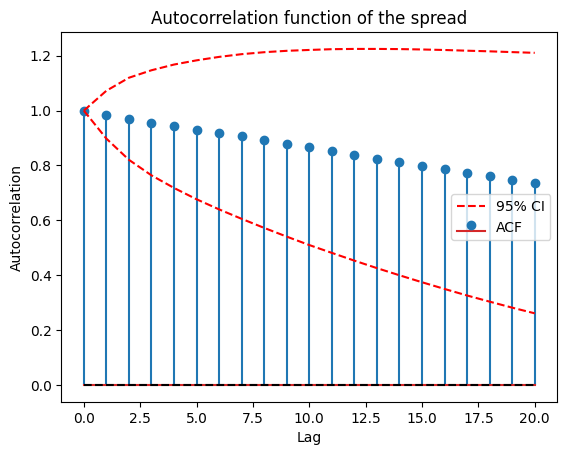

The dominant lag is 0


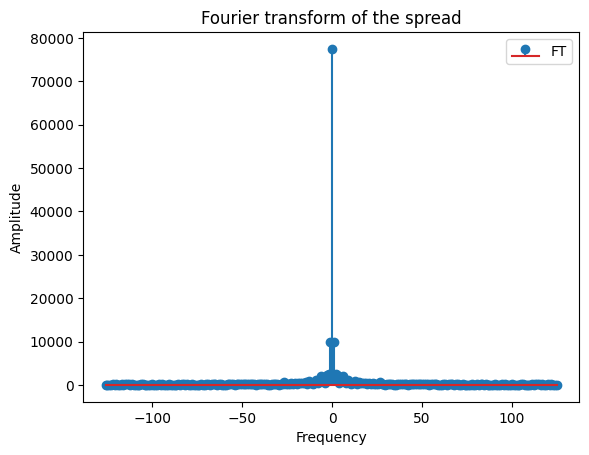

The dominant frequency is 0.0
The score is 1475.1645964664492


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

# Define the symbols of the assets
asset1 = 'AAPL'
asset2 = 'AMZN'

# Download the price data from Yahoo Finance
data1 = pd.read_csv(f"https://query1.finance.yahoo.com/v7/finance/download/{asset1}?period1=1577836800&period2=1640995200&interval=1d&events=history&includeAdjustedClose=true")
data1.index = pd.to_datetime(data1['Date'])
data1 = data1.drop('Date', axis=1)

data2 = pd.read_csv(f"https://query1.finance.yahoo.com/v7/finance/download/{asset2}?period1=1577836800&period2=1640995200&interval=1d&events=history&includeAdjustedClose=true")
data2.index = pd.to_datetime(data2['Date'])
data2 = data2.drop('Date', axis=1)

# Merge the data into one dataframe
df = pd.merge(data1, data2, left_index=True, right_index=True, suffixes=('_'+asset1, '_'+asset2))

# Use the closing prices for the analysis
close = df[['Close_'+asset1, 'Close_'+asset2]]

# Perform the Johansen cointegration test
jres = coint_johansen(close, det_order=0, k_ar_diff=1)

# Select the cointegrating vector with the highest eigenvalue and the most significant trace statistic
vec = jres.evec[:, 0]

# Normalize the vector such that the first element is one
vec = vec / vec[0]

# Form a stationary series by taking a linear combination of the price data and the cointegrating vector
spread = close.dot(vec)

# Calculate the autocorrelation function of the spread
acf = sm.tsa.stattools.acf(spread, nlags=20, alpha=0.05)

# Plot the autocorrelation function
plt.stem(range(len(acf[0])), acf[0], label='ACF')
plt.plot(range(len(acf[0])), [0] * len(acf[0]), color='black', linestyle='--')
plt.plot(range(len(acf[0])), acf[1][:, 0], color='red', linestyle='--', label='95% CI')
plt.plot(range(len(acf[0])), acf[1][:, 1], color='red', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation function of the spread')
plt.legend()
plt.show()

# Identify the dominant lag
dominant_lag = np.argmax(acf[0])
print('The dominant lag is', dominant_lag)

# Calculate the Fourier transform of the spread
ft = np.fft.fft(spread, n=256)
freq = np.fft.fftfreq(len(ft), d=1/252)

# Plot the Fourier transform
plt.stem(freq, np.abs(ft), label='FT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier transform of the spread')
plt.legend()
plt.show()

# Identify the dominant frequency
dominant_freq = freq[np.argmax(np.abs(ft))]
print('The dominant frequency is', dominant_freq)

# Calculate the score
score = np.abs(ft[np.argmax(np.abs(ft))]) / spread.std()
print('The score is', score)
